<a href="https://colab.research.google.com/github/baussel/Satellite_Detection/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classifier - Satellite vs No Satellite

---

*Ben Aussel, September 2021, ESA*

---

## Code Preparation

In [ ]:
#Installation of missing modules
!pip install wandb #Weights and Biases - For logging the training runs
!pip install pyyaml h5py  #Required to save models in HDF5 format

     |████████████████████████████████| 1.7 MB 8.3 MB/s 
     |████████████████████████████████| 133 kB 58.1 MB/s 
     |████████████████████████████████| 97 kB 8.0 MB/s 
     |████████████████████████████████| 170 kB 70.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=6b7a0b0d7e1521cbc76ed93dd6b2926f0b646a661d6821753d7a9c56b670a435
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=a63edbcc68cbe9ca98af0d38b3ab2a3f1497d9f52626db1de3ad692c42703ab2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
#Import of the relevant modules
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds

#Connection to Weight and Biases (https://wandb.ai)
import wandb
from wandb.keras import WandbCallback

## Data Preparation

In [ ]:
#Mount Google Drive with this Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Paramters for the images
img_height = 600
img_width = 600

#Batch_size - Size of used images per step
batch_size = 30

#Image Path
image_path = '/content/drive/MyDrive/ESA/Data/Zooniverse_Data/Images/Visible/'

#Class Threshold
class_threshold = 0.5

In [ ]:
#Definition of the training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split = 0.2,
    subset = "training",
    seed = 2345,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = "binary") #Maybe change color_mode to grayscale for satellites

Found 5822 files belonging to 2 classes.
Using 4658 files for training.


In [ ]:
#Definition of the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path,
  validation_split= 0.2 ,
  subset = "validation",
  seed = 2345,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  label_mode = "binary") #Maybe change color_mode to grayscale for satellites

Found 5822 files belonging to 2 classes.
Using 1164 files for validation.


In [ ]:
#Return the class names
class_names = train_ds.class_names
print("Classes:",class_names)

Classes: ['no_satellite', 'satellite']


In [ ]:
print("Shape of the Dataset:")
print(train_ds)

Shape of the Dataset:
<BatchDataset shapes: ((None, 600, 600, 3), (None, 1)), types: (tf.float32, tf.float32)>


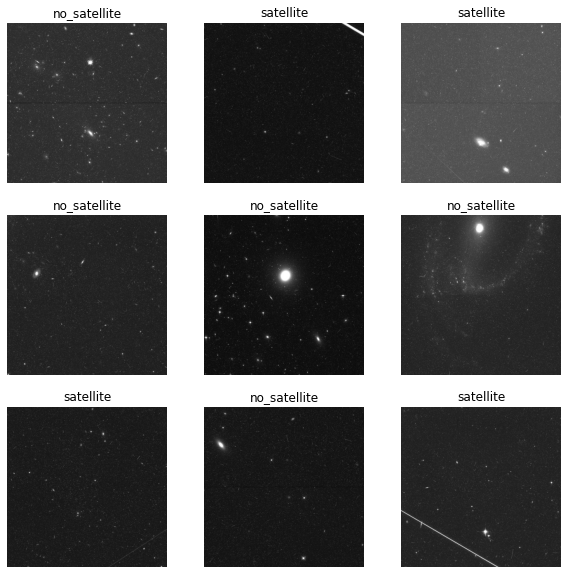

In [ ]:
#Example Images
plt.figure(figsize=(10, 10))
for images,labels in train_ds.take(1): #Takes the first batch
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Creating the model

Using the Inceptionv3 model

In [ ]:
#Use the existing InceptionV3 model for this classification
from tensorflow.keras.applications.inception_v3 import InceptionV3

#Save the model and load the downloaded weights
pre_trained_model = InceptionV3(
    input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

#Set the model to trainable
for layer in pre_trained_model.layers:
  layer.trainable = True

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
#Learning rate
learn_rate = 0.0005

In [ ]:
#Definition of the layers of the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
  pre_trained_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(128, activation = 'relu'),
  layers.Dropout(0.5),
  layers.Dense(64, activation = 'relu'),
  layers.Dropout(0.5),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
#Compiling of the model, loss function is binary
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learn_rate),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
                         #tf.keras.metrics.BinaryAccuracy(threshold=class_threshold)])

In [ ]:
#Overview over the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 600, 600, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 17, 17, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

## Training of the model

In [ ]:
#Connection to Weights and Biases
#parameters
config = wandb.config
config.learning_rate = learn_rate
wandb.init(project = 'image_classifier')

my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}.h5'),
    WandbCallback()]

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#Number_of_run
number_run = "18"

In [ ]:
#Number of epochs for the training
epoch_number = 50

#Starting the training and storing the result in 'history'
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epoch_number,
  callbacks = my_callbacks)

Epoch 1/50
156/156 [==============================] - 520s 3s/step - loss: 0.7238 - accuracy: 0.5127 - val_loss: 0.6895 - val_accuracy: 0.5335
Epoch 2/50
156/156 [==============================] - 286s 2s/step - loss: 0.7081 - accuracy: 0.5339 - val_loss: 0.6898 - val_accuracy: 0.5387
Epoch 3/50
156/156 [==============================] - 290s 2s/step - loss: 0.7040 - accuracy: 0.5268 - val_loss: 0.6791 - val_accuracy: 0.6280
Epoch 4/50
156/156 [==============================] - 290s 2s/step - loss: 0.6969 - accuracy: 0.5384 - val_loss: 0.6707 - val_accuracy: 0.6641
Epoch 5/50
156/156 [==============================] - 291s 2s/step - loss: 0.6889 - accuracy: 0.5539 - val_loss: 0.6591 - val_accuracy: 0.6684
Epoch 6/50
156/156 [==============================] - 290s 2s/step - loss: 0.6857 - accuracy: 0.5419 - val_loss: 0.6519 - val_accuracy: 0.6787
Epoch 7/50
156/156 [==============================] - 290s 2s/step - loss: 0.6797 - accuracy: 0.5565 - val_loss: 0.6392 - val_accuracy: 0.6804

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_save_path = "/content/drive/MyDrive/ESA/ML_Checkpoints/Classifier/"
model.save(model_save_path+"Image_Classifier_"+str(number_run)) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ESA/ML_Checkpoints/Classifier/Image_Classifier_18/assets


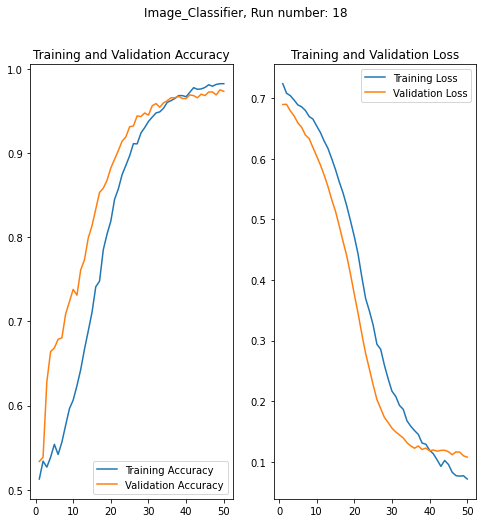

In [ ]:
#Plot the training progress

#Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

#Epochs
epochs_range = np.arange(1,len(acc)+1,1)

#Plot - Accuracy
plt.figure(figsize=(8, 8))
plt.suptitle("Image_Classifier, Run number: "+str(number_run))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

#Plot - Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig(model_save_path+"Image_Classifier_"+number_run+"/training_plot.pdf")
plt.show()

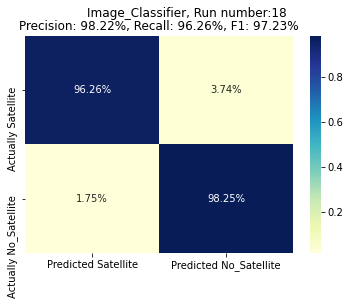

In [ ]:
#Pandas Flatten module
from pandas.core.common import flatten

#Extract labels and predictions for validation data of the model
y_pred_list = []
y_real_list = []
for images, labels in val_ds:
  #Prediction
  class_pr = (model.predict(images) > class_threshold).astype("int32")
  y_pred_list.append(class_pr)
  #Label
  lab = list(np.ndarray.flatten(labels.numpy()))
  y_real_list.append(int(item) for item in lab)
y_real = list(flatten(y_real_list))
y_pred = list(flatten(y_pred_list))

#Confusion matrix module
from sklearn.metrics import confusion_matrix
#Modules for displaying the matrix
import seaborn as sns
import pandas as pd

#Calculates the values of the matrix
confusion_matrix_scores = confusion_matrix(y_real, y_pred, labels=[1, 0], normalize = "true")

#Extract true/false positive/negative values
tp, fn, fp, tn = confusion_matrix_scores.ravel()

#Calculate precision and recall + F1 score
precision = tp / (tp + fp)
recall =  tp / (tp + fn)
F1 = 2 * precision * recall / (precision + recall)

#Draw and show the matrix
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted Satellite", "Predicted No_Satellite"],
                  index = ["Actually Satellite", "Actually No_Satellite"])
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2%")
plt.suptitle("Image_Classifier, Run number:"+str(number_run))
plt.title("Precision: {:.2%}, Recall: {:.2%}, F1: {:.2%}".format(precision,recall,F1))
plt.savefig(model_save_path+"Image_Classifier_"+number_run+"/confusion_matrix.pdf",bbox_inches='tight')
plt.show()

In [ ]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ESA/Data/Test/satellite_det/raw_images2/",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    batch_size=10,
    image_size=(600, 600),
    shuffle=True)

print("Evaluate")
result = model.evaluate(test_set)

Found 1035 files belonging to 2 classes.
Evaluate
104/104 [==============================] - 101s 869ms/step - loss: 0.0479 - accuracy: 0.9865


In [ ]:
np.save(model_save_path+"Image_Classifier_"+number_run+"/history.npy",history.history)

In [ ]:
loaded_history = np.load(model_save_path+"Image_Classifier_"+number_run+"/history.npy",allow_pickle='TRUE').item()
print(loaded_history)

{'loss': [0.7238355278968811, 0.7081186175346375, 0.7040438652038574, 0.6969074606895447, 0.6888633966445923, 0.6856988668441772, 0.679685115814209, 0.669715404510498, 0.6654028296470642, 0.6540611982345581, 0.643164873123169, 0.6290690898895264, 0.6170084476470947, 0.6001149415969849, 0.5820812582969666, 0.5618551969528198, 0.5437617897987366, 0.5218235850334167, 0.49715402722358704, 0.47156453132629395, 0.4424910545349121, 0.404654324054718, 0.3696002662181854, 0.3488738238811493, 0.32563525438308716, 0.29393869638442993, 0.28556257486343384, 0.2591056525707245, 0.23659881949424744, 0.2164614498615265, 0.20785309374332428, 0.19293847680091858, 0.18649837374687195, 0.16737565398216248, 0.1586001217365265, 0.1513681709766388, 0.14510363340377808, 0.13087041676044464, 0.1289241760969162, 0.11904836446046829, 0.1129949688911438, 0.10305957496166229, 0.09234026074409485, 0.10213907063007355, 0.09551658481359482, 0.08262816071510315, 0.077090784907341, 0.07627874612808228, 0.07684534043073

## Prediction of unknown images

### Single image

In [ ]:
#Load image
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/ESA/Data/Hubble_Images/Raw/ACS_Comp_Raw/je3909010_je3909lfq.jpg", 
    target_size = (600, 600))

#Process the image to an array and then to a batch
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #Create a batch

#Calculate the (binary) prediction
class_pr = (model.predict(img_array) > class_threshold).astype("int32") #For binary prediction
score_pr = model.predict(img_array)
if class_pr == 0:
  score_pr = 1 - score_pr

#Print the result
print("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[int(class_pr)], 100 *float(score_pr)))

### Hubble Archive

In [ ]:
#Mount Google Drive with this Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir test_predictions
class_threshold = 0.5
#Import of the relevant modules
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
import pandas as pd
from tqdm import tqdm

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/ESA/ML_Checkpoints/Classifier/Image_Classifier_18")

In [ ]:
# image folder
folder_path = "/content/drive/MyDrive/ESA/Data/Hubble_Images/Raw/ACS_Comp_Raw/"
#folder_path = "/content/drive/MyDrive/ESA/Data/satellite_det/test/"
# dimensions of images
img_width, img_height = 600, 600

predictions = []
error_ids = []

pathout = "/content/drive/MyDrive/ESA/Results/"
for img in tqdm(os.listdir(folder_path)):
    img_p = os.path.join(folder_path, img)
    try:
        img_p = image.load_img(img_p, target_size=(img_width, img_height))
    except:
        error_ids.append(img)
        continue
    img_p = image.img_to_array(img_p)
    img_p = np.expand_dims(img_p, axis=0)
    score = model.predict(img_p)
    class_pr = (score > class_threshold).astype("int32")
    ids = str(img)
    #fileout = str(img)
    #img = mpimg.imread(folder_path+img)
    #plt.imshow(img,cmap= "gray")
    if class_pr == 0:
      pred = "no_satellite"
    else:
      pred = "satellite"
    predictions.append([ids,pred,str(score[0][0])])
    #plt.title("Prediction: " + pred)
    #plt.axis('off')
    #plt.savefig(pathout + fileout, bbox_inches = 'tight',dpi=150)
    #plt.close()

100%|██████████| 78209/78209 [16:10:55<00:00,  1.34it/s]


In [ ]:
data = pd.DataFrame(predictions,columns=["filename","prediction","score"])
data.to_csv(pathout+"satellites_ACS.csv")
data
data_error = pd.DataFrame(error_ids,columns=["error_id"])
data_error.to_csv(pathout+"satellites_ACS_errors.csv")

In [ ]:
# image folder
folder_path = "/content/drive/MyDrive/ESA/Data/Hubble_Images/Raw/WFC3_UVIS_Comp_Raw/"
# dimensions of images
img_width, img_height = 600, 600

predictions = []
error_ids = []

pathout = "/content/drive/MyDrive/ESA/Results/"
for img in tqdm(os.listdir(folder_path)):
    img_p = os.path.join(folder_path, img)
    try:
        img_p = image.load_img(img_p, target_size=(img_width, img_height))
    except:
        error_ids.append(img)
        continue
    img_p = image.img_to_array(img_p)
    img_p = np.expand_dims(img_p, axis=0)
    score = model.predict(img_p)
    class_pr = (score > class_threshold).astype("int32")
    ids = str(img)
    if class_pr == 0:
      pred = "no_satellite"
    else:
      pred = "satellite"
    predictions.append([ids,pred,str(score[0][0])])

100%|██████████| 61519/61519 [13:29:17<00:00,  1.27it/s]


In [ ]:
data = pd.DataFrame(predictions,columns=["filename","prediction","score"])
data.to_csv(pathout+"satellites_WFC3_UVIS.csv")
data
data_error = pd.DataFrame(error_ids,columns=["error_id"])
data_error.to_csv(pathout+"satellites_WFC3_UVIS_errors.csv")

In [ ]:
#Zip the data to download
!zip -r /content/test_predictions.zip /content/test_predictions